# Counting Metal Sheets with CNN Methods -Part II- <a class='tocSkip'>"

**Contributors**: Moritz Geiger

# Imports

In [ ]:
import pandas as pd
import numpy as np
import requests
from io import StringIO, BytesIO
import os
from shutil import copyfile
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential, layers

## Sources

- Paper about counting from air (trees, cars): [https://arxiv.org/pdf/2102.04366v1.pdf](https://arxiv.org/pdf/2102.04366v1.pdf)
- more info on regression based methods: [https://arxiv.org/pdf/2007.01899v2.pdf](https://arxiv.org/pdf/2007.01899v2.pdf)
- basic model to count fingers: [https://analyticsindiamag.com/how-to-implement-cnn-model-to-count-fingers-and-distinguish-between-left-and-right-hand/](https://analyticsindiamag.com/how-to-implement-cnn-model-to-count-fingers-and-distinguish-between-left-and-right-hand/)
- How neural networks work: [https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480)
- load training dataset for rsoc: [https://github.com/gaoguangshuai/Counting-from-Sky-A-Large-scale-Dataset-for-Remote-Sensing-Object-Counting-and-A-Benchmark-Method](https://github.com/gaoguangshuai/Counting-from-Sky-A-Large-scale-Dataset-for-Remote-Sensing-Object-Counting-and-A-Benchmark-Method)
- Guide for CNN with pytorch: [https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce](https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce)

# Loading images

In [16]:
## load all filenames
newpath = '../raw_data/finals'
final_imgs = [os.path.join(newpath, img) for img in os.listdir(newpath)]
final_imgs

['../raw_data/finals/1_00mm_58_86_fin.jpg',
 '../raw_data/finals/1_00mm_37_-99_fin.jpg',
 '../raw_data/finals/1_00mm_47_-99_fin.jpg',
 '../raw_data/finals/1_00mm_46_152_fin.jpg',
 '../raw_data/finals/0_75mm_6_-99_fin.jpg',
 '../raw_data/finals/1_00mm_60_78_fin.jpg',
 '../raw_data/finals/1_00mm_52_-99_fin.jpg',
 '../raw_data/finals/1_5mm_7_-99_fin.jpg',
 '../raw_data/finals/1_5mm_30_-99_fin.jpg',
 '../raw_data/finals/1_00mm_10_-99_fin.jpg',
 '../raw_data/finals/1_00mm_22_110_fin.jpg',
 '../raw_data/finals/1_00mm_49_96_fin.jpg',
 '../raw_data/finals/1_00mm_4_-99_fin.jpg',
 '../raw_data/finals/1_00mm_27_-99_fin.jpg',
 '../raw_data/finals/1_00mm_15_-99_fin.jpg',
 '../raw_data/finals/1_2mm_1_63_fin.jpg',
 '../raw_data/finals/1_00mm_42_154_fin.jpg',
 '../raw_data/finals/1_5mm_20_-99_fin.jpg',
 '../raw_data/finals/1_2mm_2_59_fin.jpg',
 '../raw_data/finals/1_00mm_61_92_fin.jpg',
 '../raw_data/finals/1_2mm_3_60_fin.jpg',
 '../raw_data/finals/1_2mm_6_61_fin.jpg',
 '../raw_data/finals/1_00mm_17_2

**Note**<br>
The filenames have the following structure:<br>
```[thickness]_[id]_[sheetcount/target]_[<fin>].jpg```

In [17]:
print(f'The final dataset consists of \033[1m{len(final_imgs)}\033[0m images. Some of which are not counted ("-99") due to blurryness. That might be of interest for further analysis.')
 

The final dataset consists of 104 images. Some of which are not counted ("-99") due to blurryness. That might be of interest for further analysis.


# Exploring the dataset

The images show amateur photographs of metal sheet stacks on pallets in a warehouse during daylight conditions. The data provided contains metal sheets of sizes 0.75mm to 1.5mm. The sheets are either perforated or expanded. The perforated sheets lie horizontally on top of each other. The expanded metal forms a wavy profile when stacked.

## Examples

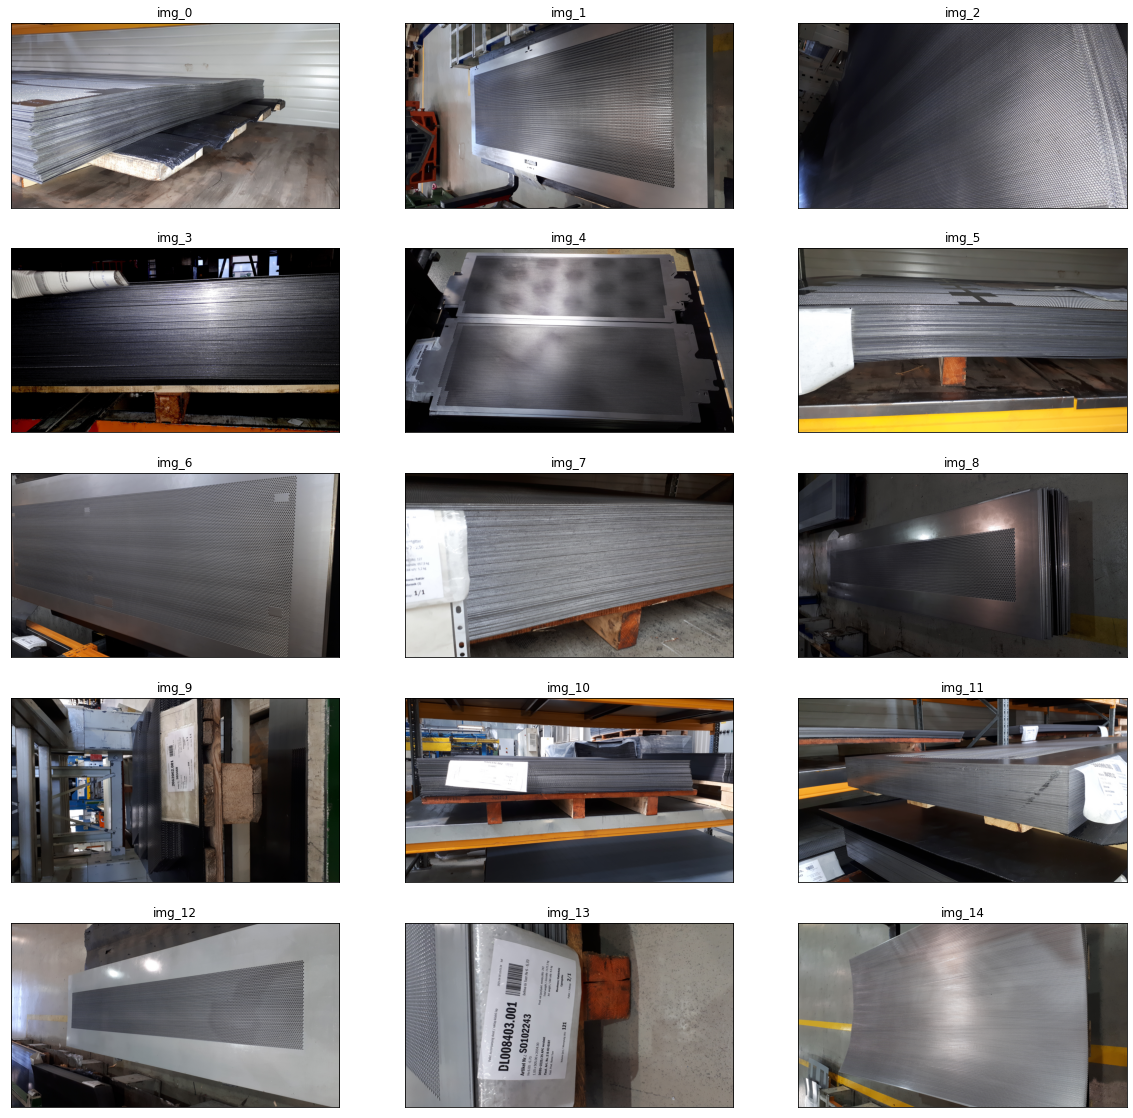

In [18]:
# showcasing some img examples
fig = plt.figure(figsize=(20,20))
for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.title(f'img_{i}', size=12)
    plt.imshow(mpimg.imread(final_imgs[i]))
    plt.xticks(())
    plt.yticks(())

## Image quality

As visible, some of the images are not usable due to blurryness wrong angles. They would add too much noise to the model and will be manually sorted out of the data set. The optimal image should show the sheet stack from the side with enough light to detect the contrast between the sheets.

In [19]:
## find img resolutions
sizes = []
for img in final_imgs:
    if 'jpg' in img:
        im = PIL.Image.open(img)
        sizes.append(im.size)

In [20]:
# all images have the same resolution
print(f'The resolution of all images is: \033[1m{sizes[0][0]}x{sizes[0][1]}px\033[0m')

The resolution of all images is: 4608x2592px


**Note**<br>
Further compressing and grayscaling will be assessed in the model tuning process.

## Target Range

In [51]:
## turning data into DF
img_dict = {'filepath':[],
            'thickness':[],
            'target':[],
           }
for img in final_imgs:
    splt = img.split('_')
    img_dict['filepath'].append(img)
    img_dict['thickness'].append(f'{splt[-5].split("/")[-1]}.{splt[-4]}')
    img_dict['target'].append(splt[-2])
    
img_df = pd.DataFrame(img_dict)
img_df['target'] = pd.to_numeric(img_df['target'])

In [52]:
# minor measurement cleaning
img_df['thickness'] = img_df['thickness'].replace({'1.0mm': '1.00mm'})

In [93]:
# showcase DF
img_df.sort_values(by='thickness', ascending=False).head(10)

,filepath,thickness,target
32,../raw_data/finals/1_5mm_31_105_fin.jpg,1.5mm,105
50,../raw_data/finals/1_5mm_33_74_fin.jpg,1.5mm,74
26,../raw_data/finals/1_5mm_9_84_fin.jpg,1.5mm,84
28,../raw_data/finals/1_5mm_12_58_fin.jpg,1.5mm,58
83,../raw_data/finals/1_5mm_4_120_fin.jpg,1.5mm,120
30,../raw_data/finals/1_5mm_36_-99_fin.jpg,1.5mm,-99
69,../raw_data/finals/1_5mm_6_-99_fin.jpg,1.5mm,-99
65,../raw_data/finals/1_5mm_2_120_fin.jpg,1.5mm,120
33,../raw_data/finals/1_5mm_18_75_fin.jpg,1.5mm,75
34,../raw_data/finals/1_5mm_26_36_fin.jpg,1.5mm,36


In [54]:
img_df.dtypes

filepath     object
thickness    object
target        int64
dtype: object

<AxesSubplot:title={'center':'Sheet Counts'}, xlabel='target', ylabel='Count'>

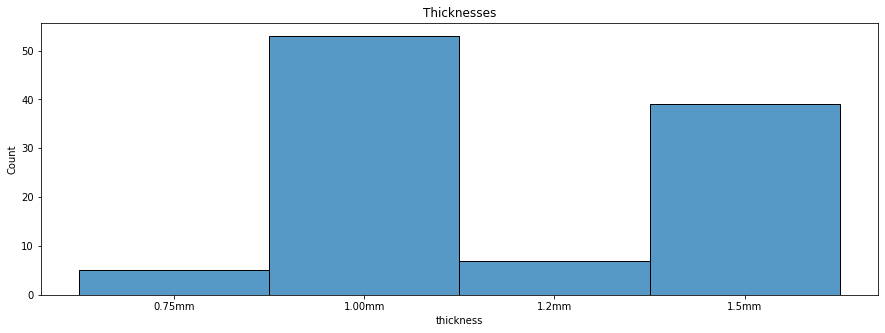

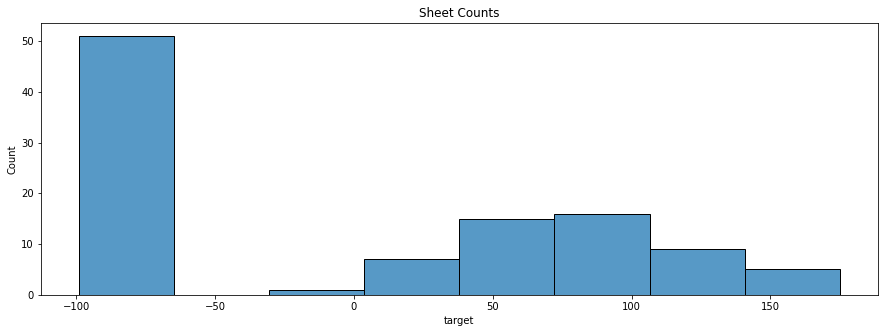

In [76]:
# distribution of dataset
plt.figure(1, figsize=(15,5))
plt.title('Thicknesses')
sns.histplot(data=img_df.thickness.sort_values())

plt.figure(2, figsize=(15,5))
plt.title('Sheet Counts')
sns.histplot(data=img_df.target.sort_values())

**Note**<br>
There is a majority of invalid counts ("-99") due to blurriness and incountability in the dataset. They should be reduced or removed. They will be useful in case a decision/classifying layer should be implemented of whether to use an image or not.  

In [85]:
# Range of counts
img_df[img_df['target']>0].target.describe()

count     53.000000
mean      82.000000
std       39.580007
min        3.000000
25%       56.000000
50%       80.000000
75%      109.000000
max      175.000000
Name: target, dtype: float64

# Read img correctly

In [97]:
final_df = img_df[img_df['target']>0].reset_index(drop=True)
# 52 imgs left

In [ ]:
# img = cv2.imread(path)


# Preprocessing

In [ ]:
# compress
# sharpness
# grayscale
# zoom?
# image transformation